In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV as gsCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Read the data
df = pd.read_csv('IDS_Dataset_Group_75.csv')


In [2]:
#remove all rows where the gender value is 'other'
dfgenders = df[df['gender'] != 'other']

dfgenders.head(104)


,Id,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
0,x6077a,male,26,German,Golf,67,False,True,False,False,2,True,bachelor,A,False
1,x2173b,male,24,Dutch,Cricket,70,False,True,False,False,1,True,master,A,True
2,x6241a,female,26,German,Golf,59,False,False,False,False,1,False,master,A,True
3,x5785d,female,27,Dutch,Tennis,63,True,True,False,False,2,True,bachelor,A,False
4,x9859f,male,28,Dutch,Cricket,63,False,True,True,False,1,False,phd,A,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,x9704c,male,31,German,Golf,58,False,False,True,False,0,False,master,A,False
100,x5556b,female,27,Dutch,Golf,74,True,True,False,True,2,True,master,A,False
101,x1117c,female,26,Dutch,Golf,68,True,True,True,False,2,True,master,A,True
103,x1369a,male,30,German,Cricket,55,False,False,False,False,0,False,bachelor,A,False


/var/folders/m_/f8zs_l8j4yv4pfrlz5kqsmkw0000gn/T/ipykernel_93530/85476756.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfgenders["all"] = ""


Text(0.5, 0, '')

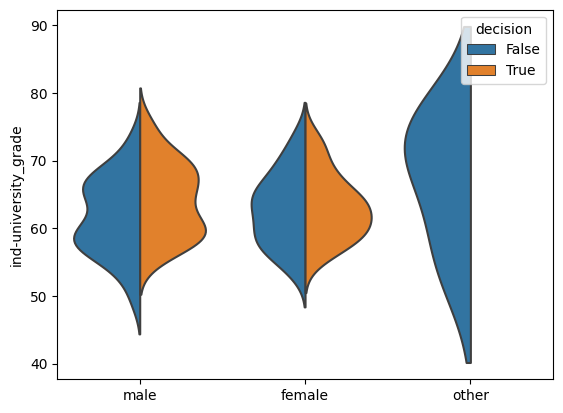

In [3]:
#make a violin plot showing the gender and age distribution
# fig, axis = plt.subplots()

#make the violin plot
# colors = {"male": 'orange', 'female': 'blue', 'other': 'green'}
# genders = set(['male', 'female'])


# for gender in genders:
#     sns.violinplot(
#         x="sport",
#         y="age",
#         hue="ind-programming_exp",
#         data = dfgenders[dfgenders['gender'] == gender],
#         split=True,
#         ax=axis,
#         scale="count",
#         scale_hue=False,
#         saturation=1,
#         inner=None
#     )
dfgenders = df[df['gender'] != 'other']
dfgenders["all"] = ""
ax = sns.violinplot(x = "gender", y="ind-university_grade", hue = 'decision', data = df, split=True, inner=None)
ax.set_xlabel("")



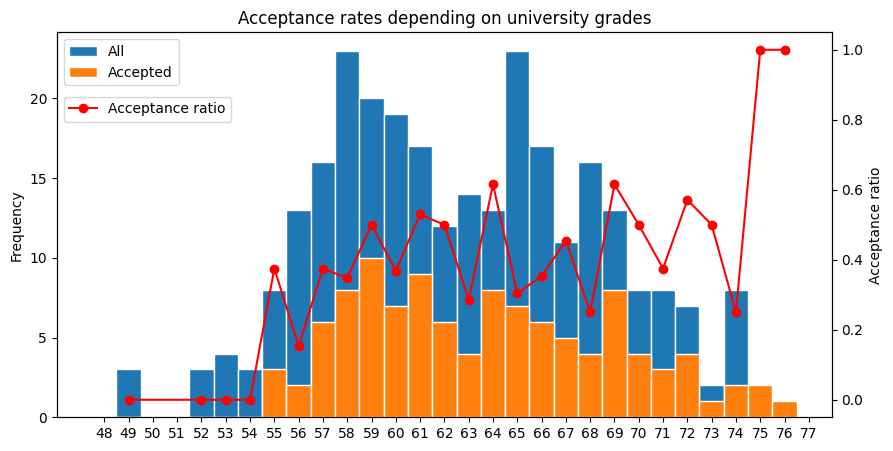

In [4]:
#make a copy of the dataframe and count how many rows decision==True for each unique grade
dfgrades = df.copy()
dfgrades = dfgrades[dfgrades['decision'] == True]

#get the counts of instances for each unique grade in total
dfcounts1 = pd.DataFrame()
dfcounts2 = pd.DataFrame()
dfcounts1[['allgrades', 'all']] = df['ind-university_grade'].value_counts().to_frame().reset_index()
dfcounts2[['acceptedgrades', 'accepted']] = dfgrades['ind-university_grade'].value_counts().to_frame().reset_index()

#sort the values of both allgrades and acceptedgrades in ascending order
dfcounts1 = dfcounts1.sort_values(by=['allgrades'])
dfcounts2 = dfcounts2.sort_values(by=['acceptedgrades'])

#reset the indexes to the current order
dfcounts2 = pd.concat([dfcounts2, pd.DataFrame(0, columns=['accepted'], index=range(4))], ignore_index=True)
dfcounts2 = dfcounts2.shift(4)


#merge the datasets on index
dfcounts1.reset_index(drop=True, inplace=True)
dfcounts = pd.concat([dfcounts1, dfcounts2], axis=1)

#create a new column with the ratio of accepted/total
dfcounts['ratio'] = dfcounts['accepted']/dfcounts['all']

#replace all NaN values with 0
dfcounts = dfcounts.fillna(0)

#display
dfcounts.head(40)





#plot the histogram
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
bin = np.arange(48, 78, 1)

ax1.hist(df['ind-university_grade'], bins=bin, edgecolor = 'white', width = 1, align='left')
ax1.hist(dfgrades['ind-university_grade'], bins=bin, edgecolor = 'white', width = 1, align='left')
ax1.set_ylabel("Frequency")
ax1.legend(["All", "Accepted"], loc='upper left', bbox_to_anchor=(0.0, 1.0))

#plot a line for the ratio
ax2.plot(dfcounts['allgrades'], dfcounts['ratio'], 'o-', color='red')
ax2.legend(["Acceptance ratio"], loc='center left', bbox_to_anchor=(0.0, 0.8))
ax2.set_ylabel("Acceptance ratio")

plt.xticks(np.arange(48, 78, 1))
plt.xlabel("University Grade")
plt.title("Acceptance rates depending on university grades")

plt.show()



In [5]:
#create a subset of the data to be used for a decision tree
dftree = df.copy()
dftree.drop(['Id', 'gender', 'sport', 'ind-languages', 'company', 'ind-exact_study'], axis=1, inplace=True)

dftree = pd.get_dummies(dftree, columns=['nationality'], drop_first=True)
labelencoder = LabelEncoder()
dftree['ind-degree'] = labelencoder.fit_transform(dftree['ind-degree'])

dftreefeatures = dftree.copy()
dftreeclasses = dftree['decision']
dftreefeatures.drop(['decision'], axis=1, inplace=True)

In [6]:
#split the set into training, validation and testing sets
X_train, X_test, y_train, y_test = tts(dftreefeatures, dftreeclasses, test_size=0.3)
X_train, X_val, y_train, y_val = tts(X_train, y_train, test_size=0.2)

y_train = y_train.tolist()
y_val = y_val.tolist()
y_test = y_test.tolist()


In [7]:
def findhp(n):
    for _ in range(n):
        param_grid = {'criterion': ['gini', 'entropy'],
                    'max_depth': [None, 1, 2, 3, 4, 5, 10, 20]}
        grid = gsCV(DecisionTreeClassifier(), param_grid, cv=5)
        grid.fit(X_train, y_train)

        print("Best hyperparameters:", grid.best_params_)


findhp(5)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 5}
Best hyperparameters: {'criterion': 'entropy', 'max_depth': None}
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 20}
Best hyperparameters: {'criterion': 'gini', 'max_depth': 1}
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 20}


In [8]:
def evalresults(actual, predicted):
    #convert predicted into a normal list
    predicted = predicted.tolist()

    correct = 0
    Tpcorrect = 0
    Trcorrect = 0
    Fpcorrect = 0
    Frcorrect = 0

    #count the number of true's in the actual set
    true = actual.count(True)

    #calculate the precision and recall for each class
    for i in range(len(actual)):
        if predicted[i] == True and actual[i] == True:
            correct += 1
            Tpcorrect += 1
            Trcorrect += 1
        elif predicted[i] == False and actual[i] == False:
            correct += 1
            Fpcorrect += 1
            Frcorrect += 1
        
    print("Accuracy:", correct/len(actual))
    print("Precision (True):", Tpcorrect/predicted.count(True))
    print("Recall (True):", Trcorrect/true)
    print("Precision (False):", Fpcorrect/predicted.count(False))
    print("Recall (False):", Frcorrect/(len(actual)-true))

#initialize the tree
clf = DecisionTreeClassifier(criterion='gini', max_depth=5)
clf.fit(X_train, y_train)

#predict the classes for the validation set
y_pred = clf.predict(X_val)

#evaluate the results
evalresults(y_val, y_pred)


Accuracy: 0.65
Precision (True): 0.5263157894736842
Recall (True): 0.6666666666666666
Precision (False): 0.7619047619047619
Recall (False): 0.64


[Text(0.5675675675675675, 0.9166666666666666, 'x[6] <= 0.5\ngini = 0.474\nsamples = 158\nvalue = [97, 61]'),
 Text(0.31756756756756754, 0.75, 'x[3] <= 0.5\ngini = 0.367\nsamples = 91\nvalue = [69, 22]'),
 Text(0.14864864864864866, 0.5833333333333334, 'x[1] <= 58.5\ngini = 0.441\nsamples = 61\nvalue = [41, 20]'),
 Text(0.05405405405405406, 0.4166666666666667, 'x[1] <= 54.5\ngini = 0.305\nsamples = 32\nvalue = [26, 6]'),
 Text(0.02702702702702703, 0.25, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.08108108108108109, 0.25, 'x[0] <= 29.5\ngini = 0.375\nsamples = 24\nvalue = [18, 6]'),
 Text(0.05405405405405406, 0.08333333333333333, 'gini = 0.432\nsamples = 19\nvalue = [13, 6]'),
 Text(0.10810810810810811, 0.08333333333333333, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.24324324324324326, 0.4166666666666667, 'x[0] <= 26.5\ngini = 0.499\nsamples = 29\nvalue = [15, 14]'),
 Text(0.1891891891891892, 0.25, 'x[1] <= 60.5\ngini = 0.388\nsamples = 19\nvalue = [14, 5]'),
 Text(0.16216

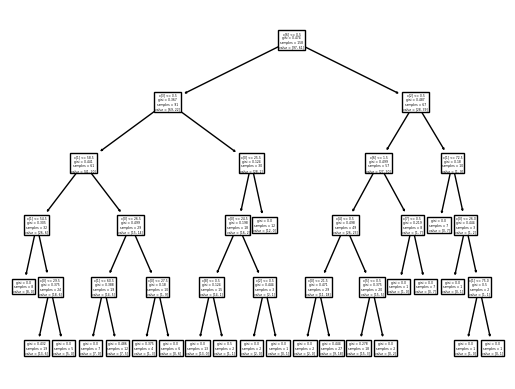

In [9]:
#print the tree
tree.plot_tree(clf)

In [10]:
#test it on the test sets
y_pred = clf.predict(X_test)
evalresults(y_test, y_pred)

Accuracy: 0.6744186046511628
Precision (True): 0.5882352941176471
Recall (True): 0.5882352941176471
Precision (False): 0.7307692307692307
Recall (False): 0.7307692307692307
